# Solutions for HA1 - Sophia Wilson - 02.11.2025

## 2 Digits Classification with K Nearest Neighbors

Training points shape: (1877, 784)
Training labels shape: (1877,)


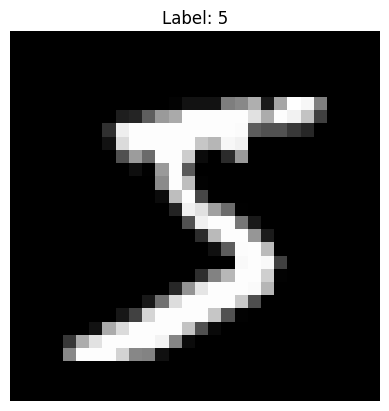

Original training labels: [5. 5. 6. ... 6. 5. 6.]
Converted training labels: [-1 -1  1 ...  1 -1  1]


In [139]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

# Importing data
X_data = np.loadtxt('MNIST-5-6-Subset/MNIST-5-6-Subset.txt').reshape(1877, 784)
y_data = np.loadtxt('MNIST-5-6-Subset/MNIST-5-6-Subset-Labels.txt')

# Print shapes
print("Training points shape:", X_data.shape)
print("Training labels shape:", y_data.shape)

# Assuming you want to visualize the first image
# Change the index as needed
image_index = 0
image_data = X_data[image_index]
selected_label = int(y_data[image_index])

# Visualize the image using Matplotlib
# We transpose the image to make the number look upright.
plt.imshow(image_data.reshape(28,28).transpose(1,0), cmap='gray')
plt.title(f"Label: {selected_label}")
plt.axis('off') # Turn off axis
plt.show()

# Convert training labels from (5, 6) to (-1, 1)
print("Original training labels:", y_data)
y_data = np.where(y_data == 5, -1, 1)
print("Converted training labels:", y_data)

In [140]:
def knn(training_points, training_labels, test_point, test_labels):
    """
    Vectorized kNN validation error for all k = 1..m (m = number of training samples).

    Assumes columns are points:
        X_train: (d, m)
        y_train: (m,)
        X_test:  (d, n)
        y_test:  (n,)

    Returns:
        errors_k: (m,)  where errors_k[k-1] is the mean classification error at k neighbors.
    """

    # Basic sizes
    m = training_points.shape[1]
    n = test_point.shape[1]

    # Ensure shape conventions. If needed, transpose
    #if training_points.shape[0] != m:
    #    training_points = training_points.T
    #    print("Transposed training points")
    #if test_point.shape[0] != n:
    #    test_point = test_point.T

    # --- Pairwise squared distances D[i, j] = ||x_i - z_j||^2 ---
    # Precompute norms (column-wise) and the cross term
    train_norm2  = (training_points**2).sum(axis=0).reshape((m, 1))  # (m, 1)
    test_norm2   = (test_point**2).sum(axis=0).reshape((1, n))       # (1, n)
    crossproduct = training_points.T @ test_point                    # (m, n)

    D = train_norm2 + test_norm2 - 2 * crossproduct                        # (m, n)

    ### --- Sort training indices by distance for each test point ---
    sorted_idx = np.argsort(D, axis=0)                              # (m, n), nearest to farhest
    sorted_labels = training_labels[sorted_idx]                     # (m, n)

    # --- Cumulative majority vote correctness for k=1..m ---
    # correct[k, j] = True if k-th neighbor (for test j) has the true label
    correct = (sorted_labels == test_labels.reshape((1, n)))        # (m, n)

    # Map True/False to +1/-1 and take cumulative sums down the neighbour axis
    votes = np.where(correct, 1, -1).cumsum(axis=0)                 # (m, n)

    # A test point is misclassified at k if the cumulative vote is <= 0
    misclassified = (votes <= 0)

    # Mean over test points gives error curve over k
    validation_error = misclassified.mean(axis=1)                           # (m,)

    return validation_error


In [141]:
def run_knn_experiment(X_data, y_data, m=50, n=10):
    """
    Run kNN validation error experiment with given m (train size) and n (val size).
    Splits data into 1 training set (size m) and 5 validation sets (each size n).
    Plots validation error curves vs K.

    Parameters
    ----------
    X_data : array, shape (features, samples) or (samples, features)
        Input data (MNIST flattened digits).
    y_data : array, shape (samples,)
        Labels corresponding to X_data.
    m : int
        Number of training samples.
    n : int
        Number of samples per validation set.
    """

    # Ensure columns are points: (features, samples)
    if X_data.shape[0] != 784 and X_data.shape[1] == 784:
        X_data = X_data.T

    X_train = X_data[:, :m]
    y_train = y_data[:m]

    # Build 5 validation sets
    val_sets = []
    for i in range(5):
        start = m + i * n
        end = m + (i + 1) * n
        X_val = X_data[:, start:end]
        y_val = y_data[start:end]
        val_sets.append((X_val, y_val))

    # Compute validation errors for each set
    validation_errors = [knn(X_train, y_train, X_val, y_val) for X_val, y_val in val_sets]

    # Plot
    Ks = np.arange(1, m + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(Ks, np.array(validation_errors).T)
    plt.xlabel("Number of neighbors K")
    plt.ylabel("Validation error")
    plt.title(f"Validation error vs K (m={m}, n={n})")
    plt.legend([f"Validation set {i+1}" for i in range(5)])
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5) 
    plt.ylim(0,1)
    plt.show()

    return validation_errors

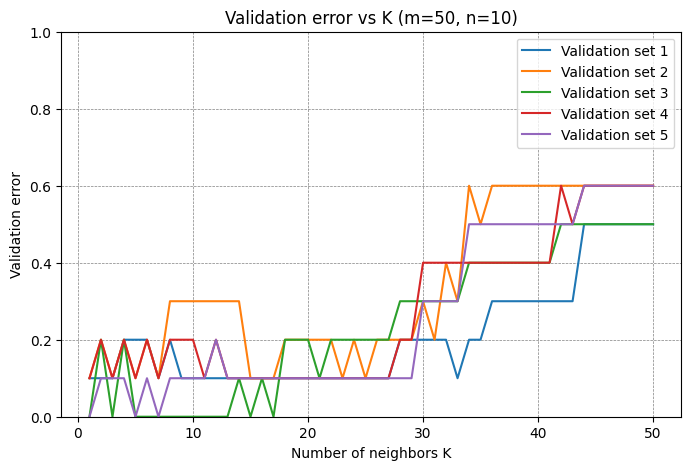

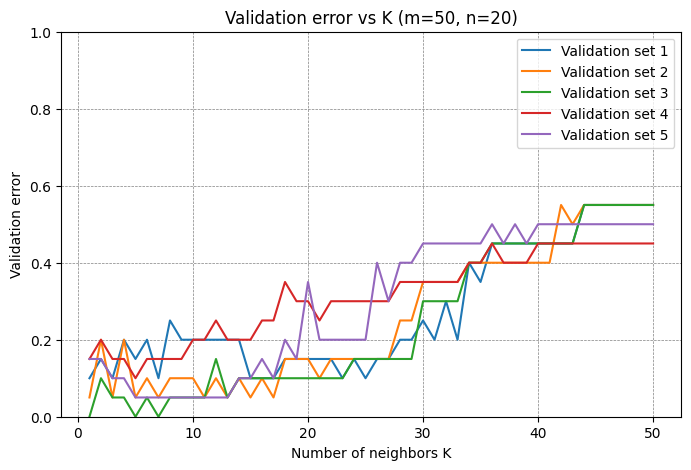

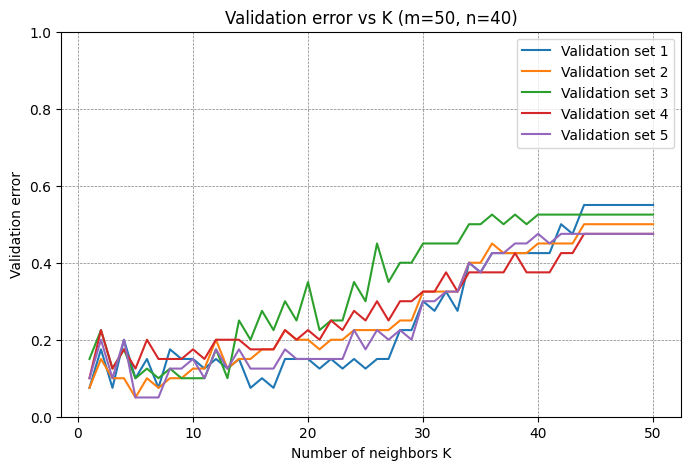

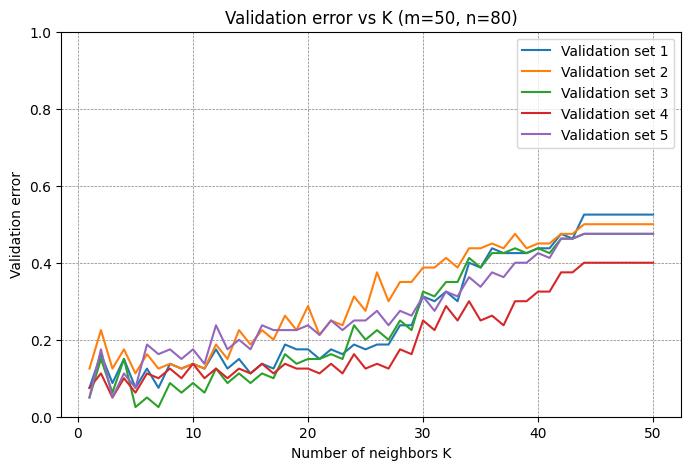

In [142]:
variances = []

for n in [10, 20, 40, 80]:
    validation_errors = run_knn_experiment(X_data, y_data, m=50, n=n)
    var = np.var(validation_errors, axis=0)
    variances.append(var)

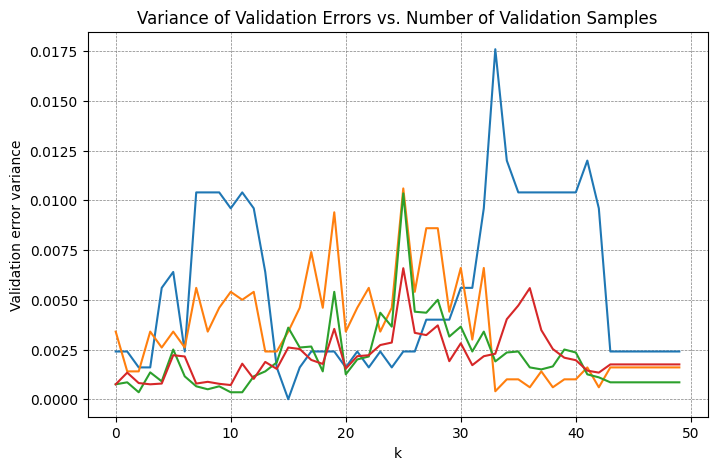

In [143]:
plt.figure(figsize=(8, 5))
for var in variances:
    plt.plot(var)
plt.xlabel("k")
plt.ylabel("Validation error variance")
plt.title("Variance of Validation Errors vs. Number of Validation Samples")
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

## Regression

In [144]:
# load data
data = np.loadtxt('PCB.dt')

In [145]:
# This algorithm computes the best-fit line through a set of 2D points by minimizing the sum of squared vertical errors.

def lin_reg_1D(data):
    # Build the design matrix X: first column = inputs x, second column = 1's (for bias b)
    X = np.concatenate((data[:, 0].reshape(-1, 1), np.ones(len(data)).reshape(-1, 1)), axis=1)
    Y = data[:, 1].reshape(-1, 1)
    
    # Solve the normal equations: (X^T X)^(-1) X^T Y
    res = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), Y)
    return res

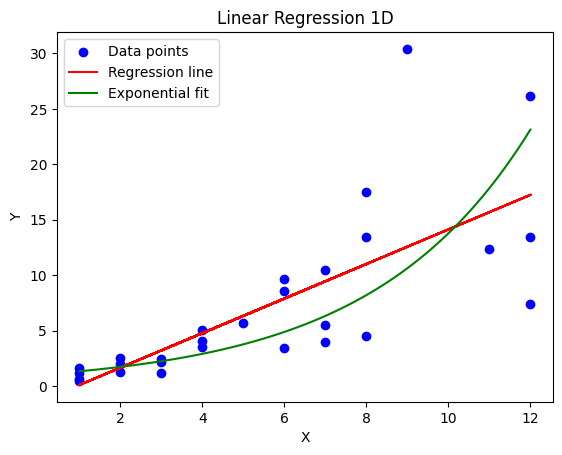

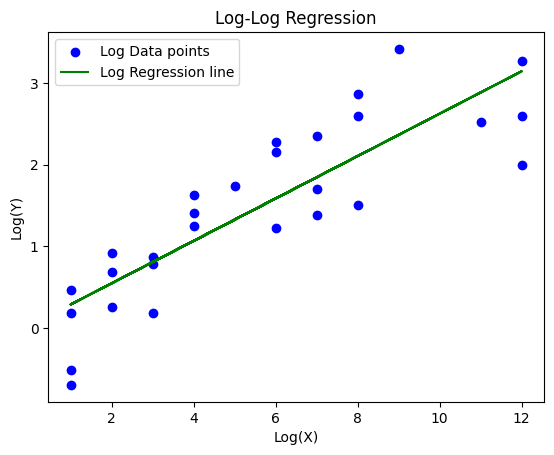

In [146]:
# Linear model
res = lin_reg_1D(data)

# Non-linear model. Take the logarithmic of the y values
data_log = data.copy()
data_log[:, 1] = np.log(data_log[:, 1])

res_log = lin_reg_1D(data_log)
x_linspace = np.linspace(data[:, 0].min(), data[:, 0].max(), 100)

plt.scatter(data[:, 0], data[:, 1], color='blue', label='Data points')
plt.plot(data[:, 0], res[0] * data[:, 0] + res[1], color='red', label='Regression line')
plt.plot(x_linspace, np.exp(res_log[0] * x_linspace + res_log[1]), color='green', label='Exponential fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression 1D')
plt.legend()
plt.show()

# plot log fit on log data
plt.figure()
plt.scatter(data_log[:, 0], data_log[:, 1], color='blue', label='Log Data points')
plt.plot(data_log[:, 0], res_log[0] * data_log[:, 0] + res_log[1], color='green', label='Log Regression line')
plt.xlabel('Log(X)')
plt.ylabel('Log(Y)')
plt.title('Log-Log Regression')
plt.legend()
plt.show()

In [147]:
# Print parameters and MSE
print("Linear model parameters (w, b):", res.flatten())
print("Linear model MSE:", np.mean((data[:, 1] - (res[0] * data[:, 0] + res[1])) ** 2))

print("Non-linear model parameters (a, b):", res_log.flatten())
print("Non-linear model MSE:", np.mean((data[:, 1] - np.exp(res_log[0] * data[:, 0] + res_log[1])) ** 2))

print("Non-linear model MSE (log data):", np.mean((data_log[:, 1] - (res_log[0] * data_log[:, 0] + res_log[1])) ** 2))

Linear model parameters (w, b): [ 1.55777052 -1.45194395]
Linear model MSE: 24.80106431657058
Non-linear model parameters (a, b): [0.25912824 0.03147247]
Non-linear model MSE: 34.83556116722035
Non-linear model MSE (log data): 0.29853492489386185


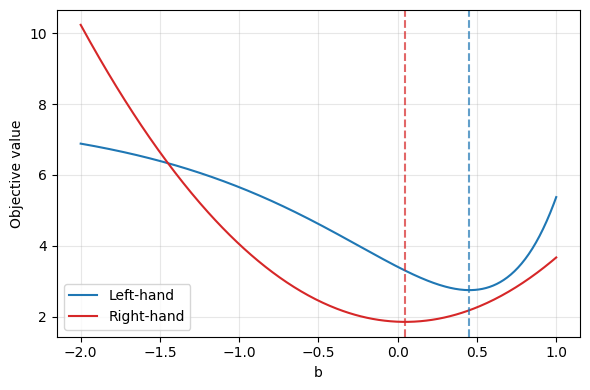

Argmin b (Left-hand): 0.4529
Argmin b (Right-hand): 0.0469


In [148]:
import numpy as np
import matplotlib.pyplot as plt

# two points with x=0
y1 = 0.4
y2 = np.exp(1.01)
ys   = np.array([y1, y2])           # shape (2,)
logs = np.log(ys)                   # shape (2,)

def lhs(b):  # sum_i (y_i - exp(b))^2
    b = np.asarray(b)
    eb = np.exp(b)
    if eb.ndim == 0:                       # scalar b
        return np.sum((ys - eb)**2)
    diffs = ys[:, None] - eb[None, :]      # (2,1) vs (1,N) -> (2,N)
    return np.sum(diffs**2, axis=0)        # -> (N,)

def rhs(b):  # sum_i (log y_i - b)^2
    b = np.asarray(b)
    if b.ndim == 0:
        return np.sum((logs - b)**2)
    diffs = logs[:, None] - b[None, :]     # (2,1) vs (1,N) -> (2,N)
    return np.sum(diffs**2, axis=0)

# grid and argmins
b_grid = np.linspace(-2.0, 1.0, 400)
b_star_lhs = np.log(np.mean(ys))           # argmin for left-hand
b_star_rhs = np.mean(logs)                 # argmin for right-hand

# plot
plt.figure(figsize=(6,4))
plt.plot(b_grid, lhs(b_grid), label="Left-hand", color='C0')
plt.plot(b_grid, rhs(b_grid), label="Right-hand", color='C3')
plt.axvline(b_star_lhs, ls='--', color='C0', alpha=0.7)
plt.axvline(b_star_rhs, ls='--', color='C3', alpha=0.7)
plt.xlabel("b"); plt.ylabel("Objective value")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()

print(f"Argmin b (Left-hand): {b_star_lhs:.4f}")
print(f"Argmin b (Right-hand): {b_star_rhs:.4f}")


In [149]:
def r2_score(y_true, y_pred):
    """
    Compute coefficient of determination (R^2).
    """
    ss_res = np.sum((y_true - y_pred) ** 2)         # residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) # total sum of squares
    return 1 - ss_res / ss_tot

print("Linear model R^2:", r2_score(data[:,1], (res[0] * data[:, 0] + res[1])))
print("Non-linear model R^2:", r2_score(data[:,1], np.exp(res_log[0] * data[:, 0] + res_log[1])))

Linear model R^2: 0.5422279075635534
Non-linear model R^2: 0.3570135731609865


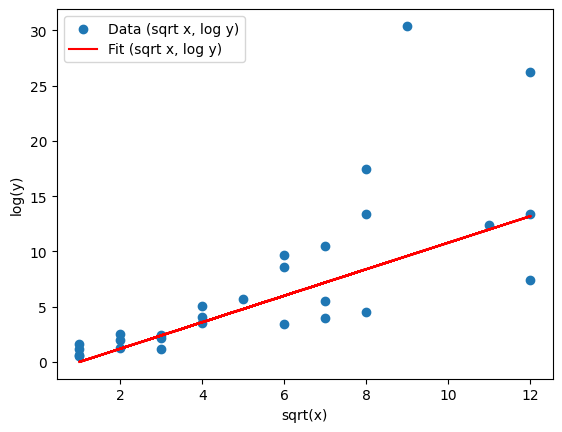

In [150]:
# Non-linear model. Take the logarithmic of the y values and sqrt of the x values
data_sqrt = data.copy()
data_sqrt[:, 0] = np.sqrt(data_sqrt[:, 0])
data_sqrt[:, 1] = np.log(data_sqrt[:, 1])

res_sqrt = lin_reg_1D(data_sqrt)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], label='Data (sqrt x, log y)')
plt.plot(data[:, 0], res_sqrt[0] * data[:, 0] + res_sqrt[1], color='red', label='Fit (sqrt x, log y)')
plt.xlabel('sqrt(x)')
plt.ylabel('log(y)')
plt.legend()
plt.show()

In [151]:
# Extract model params from regression
a, b = res_sqrt.flatten()

# Predictions in original space
x_original = data[:, 0]
y_true = data[:, 1]
y_pred = np.exp(a * np.sqrt(x_original) + b)

# Compute R^2
R2 = r2_score(y_true, y_pred)
print("Non-linear sqrt model R^2 (original scale):", R2)

# For completeness, R^2 in the transformed space (log y, sqrt x)
y_log = np.log(y_true)
x_sqrt = np.sqrt(x_original)
y_pred_log = a * x_sqrt + b
R2_log = r2_score(y_log, y_pred_log)
print("Non-linear sqrt model R^2 (log scale):", R2_log)

Non-linear sqrt model R^2 (original scale): 0.4816250669292411
Non-linear sqrt model R^2 (log scale): 0.7861056451320498
